# Time series regression models

The basic concept is that we forecast the time series of interest y assuming that it has a linear relationship with other time series х.
For example, we might wish to forecast monthly sales y using total advertising spend x as a predictor. Or we might forecast daily electricity demand y using temperature $x_1$ and the day of week $x_2$ as predictors.

## Linear regression modelling

### Simple model

$y_t=\beta_0+\beta_1 x_t + \epsilon_t$.

- The intercept  β0  represents the predicted value of  y  when  x=0 . 
- The slope  β1  represents the average predicted change in  y  resulting from a one unit increase in  x .

### Example: US consumption expenditure


In [478]:
from tsdata.raw import available_data, load_data
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from scipy.stats import linregress

import numpy as np
# plotting
from plotnine import (ggplot, geom_line, xlab, ylab, ggtitle, aes, theme, 
                     geom_density, geom_histogram, after_stat, geom_ribbon, geom_smooth,
                      facet_wrap,  geom_point, scale_color_manual, scale_alpha_manual)

plt.style.use('Solarize_Light2')


In [399]:
us_change_df = load_data("us_change").assign(
    Date=lambda df: pd.to_datetime(df.Quarter.str.replace(" ", "-"))
).drop("Quarter", axis=1).set_index("Date")

us_change_df.head(3)

,Consumption,Income,Production,Savings,Unemployment
Date,,,,,
1970-01-01,0.618566,1.044801,-2.452486,5.299014,0.9
1970-04-01,0.451984,1.225647,-0.551459,7.789894,0.5
1970-07-01,0.872872,1.585154,-0.358652,7.403984,0.5


Text(0.5, 1.0, 'US % Change in Consumption (y) and Income (x)')

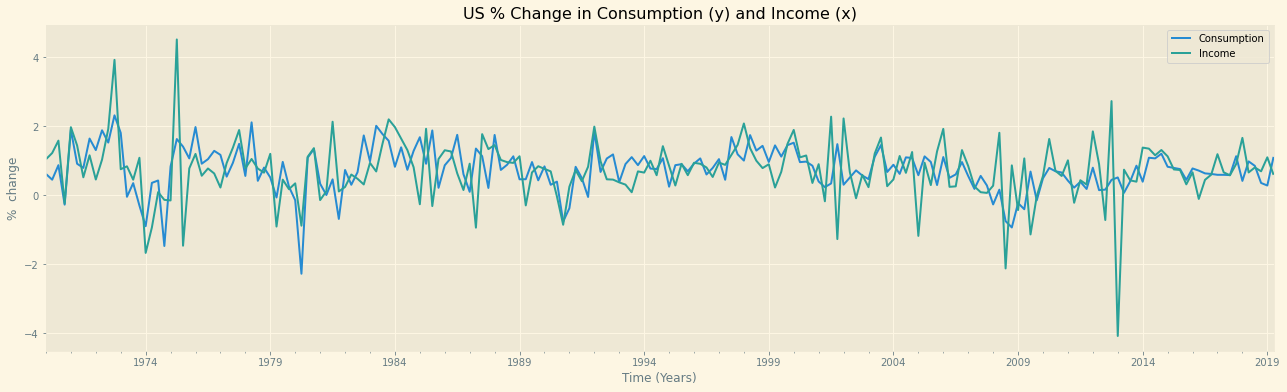

In [400]:
ax = us_change_df[["Consumption", "Income"]].plot(figsize=(22, 6))
ax.set_xlabel("Time (Years)")
ax.set_ylabel("%  change")
ax.set_title("US % Change in Consumption (y) and Income (x)")

In [5]:
consumption_regression = linregress(us_change_df.Income, us_change_df.Consumption)
b0, b1 = [consumption_regression.intercept, consumption_regression.slope]


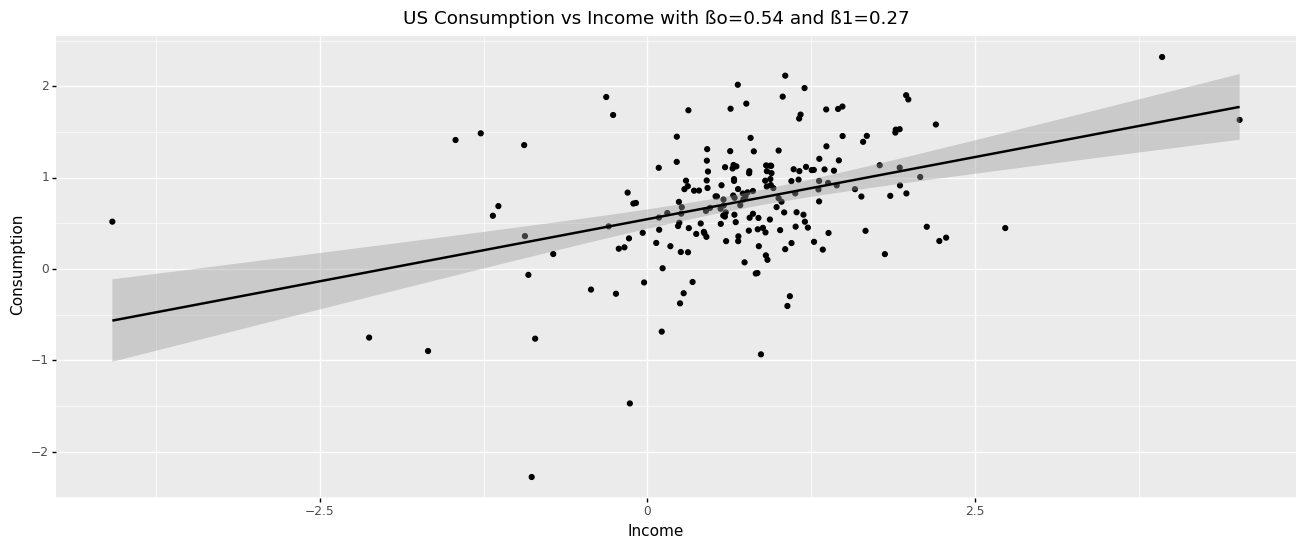

<ggplot: (8768611899426)>

In [401]:
consumption_regression = linregress(us_change_df.Income, us_change_df.Consumption)
b0, b1 = [consumption_regression.intercept, consumption_regression.slope]

(ggplot(us_change_df) +
    aes(x='Income', y='Consumption') +
    geom_point() +
    geom_smooth(method='lm') +
    ggtitle("US Consumption vs Income with ßo={:2.2f} and ß1={:2.2f}".format(b0, b1)) +
    theme(figure_size=(16, 6))
)

The interpretation of the intercept requires that a value of   x = 0 makes sense. We have negative values, because the percentage is considered compared to last year. So, it can be an increase, but also, it can be a decrease. $\beta_0$ is the average increase when x=0. Even if there is no increase in income, there is still a 0.54% increase in consumption.

#### Example: US consumption expenditure

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

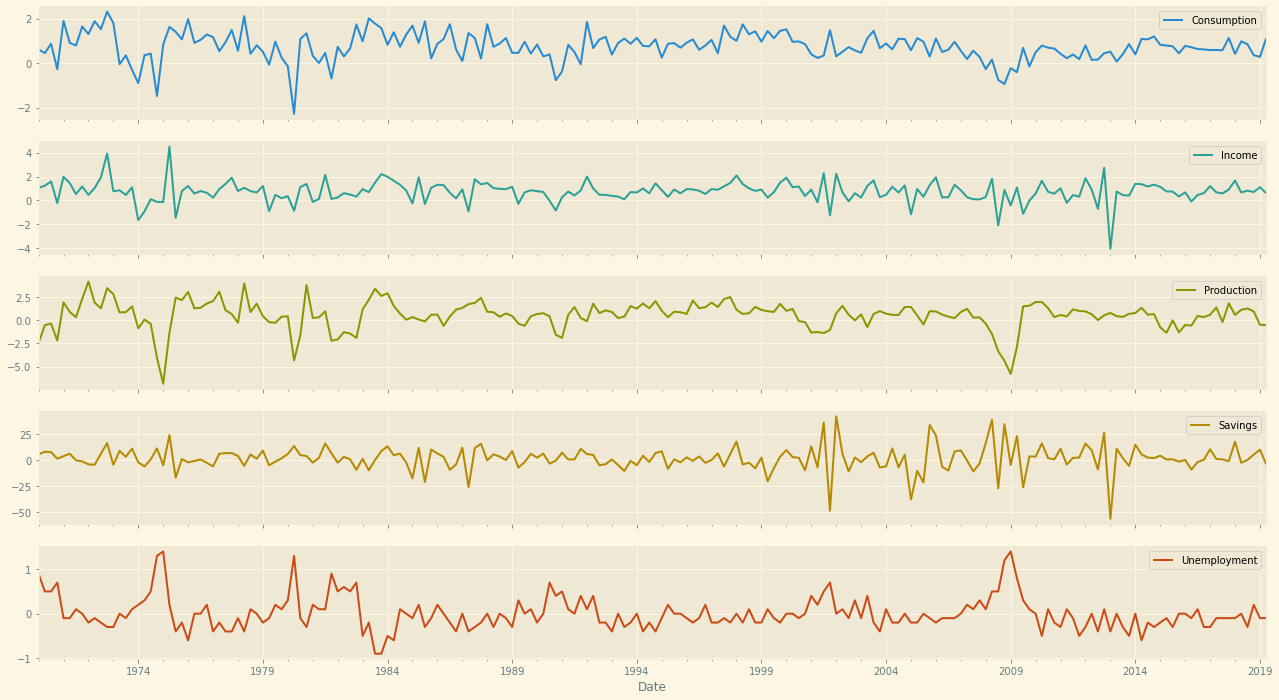

In [402]:
us_change_df.plot(subplots=True, figsize=(22, 12))
# These are quarterly percentage changes in industrial production and personal savings,
# and quarterly changes in the unemployment rate (as this is already a percentage).

We can also use a pair plot to see any relationships with the Consumption.

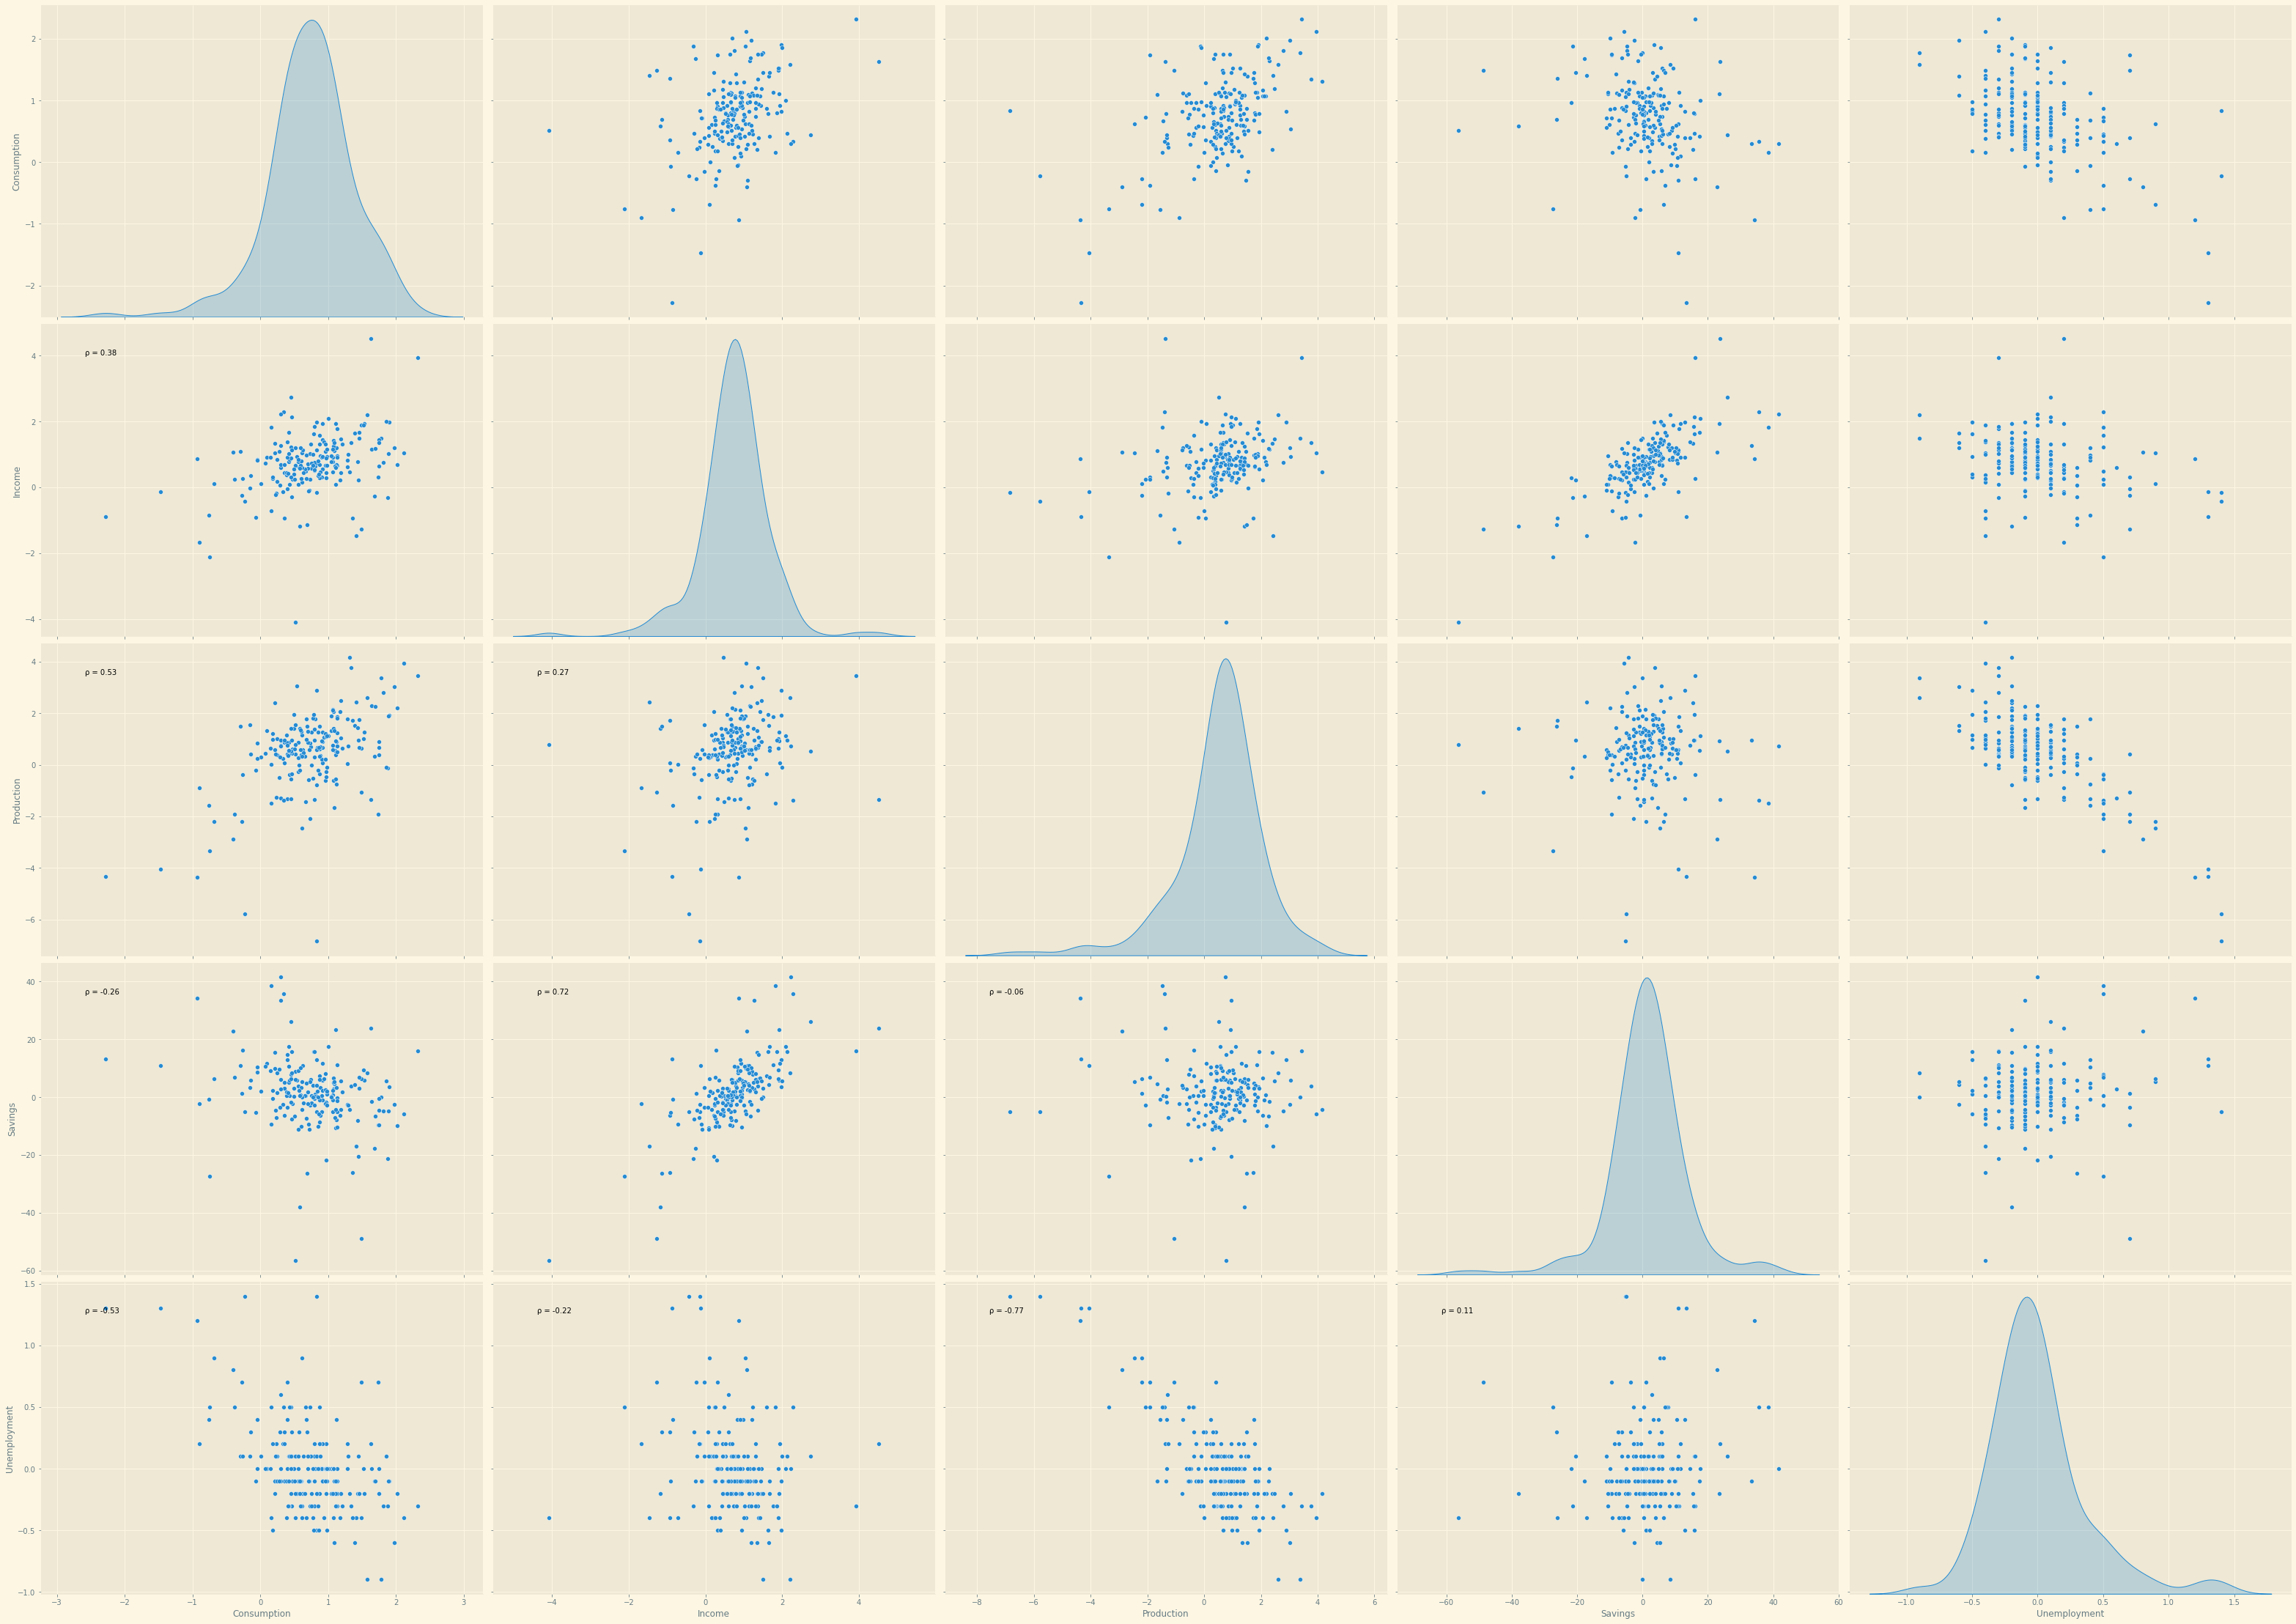

In [403]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

# TODO: move this in a separate file
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

g = sns.pairplot(us_change_df, diag_kind='kde', height=6.27, aspect=11.7/8.27)
g.map_lower(corrfunc)
plt.show()


**When me use linear regression, we use it to explain the target variable y or to make predictions if we know what the x variables would be.**

#### Assumptions

- they have mean zero; otherwise the forecasts will be systematically biased.
- they are not autocorrelated; otherwise the forecasts will be inefficient, as there is more information in the data that can be exploited.
- they are unrelated to the predictor variables; otherwise there would be more information that should be included in the systematic part of the model.

It is also useful to have the errors being normally distributed with a constant variance  σ2 in order to easily produce prediction intervals.


In [404]:
import numpy as np
import statsmodels.formula.api as sm
from statsmodels.formula.api import ols

us_change_X = us_change_df.drop('Consumption', axis=1).values
us_change_y = us_change_df.Consumption.values

us_change_fitted = ols(
    formula="Consumption ~ Income + Production + Savings + Unemployment",
    data=us_change_df
).fit()

print(us_change_fitted.summary())
# us_change_fitted = reg_m(us_change_y, us_change_X)



                            OLS Regression Results                            
Dep. Variable:            Consumption   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     160.0
Date:                Tue, 08 Mar 2022   Prob (F-statistic):           3.93e-60
Time:                        13:07:24   Log-Likelihood:                -46.660
No. Observations:                 198   AIC:                             103.3
Df Residuals:                     193   BIC:                             119.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.2531      0.034      7.343   

<AxesSubplot:xlabel='Date'>

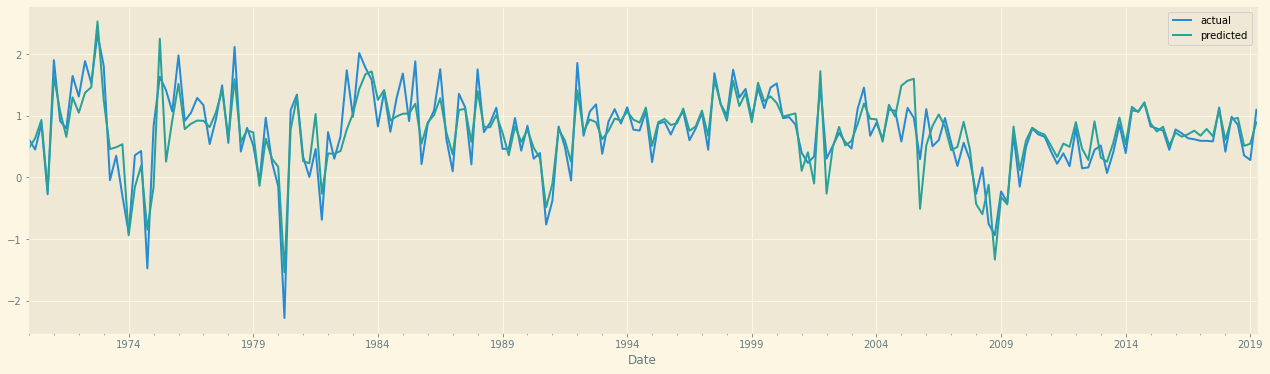

In [407]:
us_change_model_results_df = pd.DataFrame({
    'actual': us_change_y, 'predicted': us_change_fitted.predict(us_change_df)
})

us_change_model_results_df.plot(figsize=(22, 6))


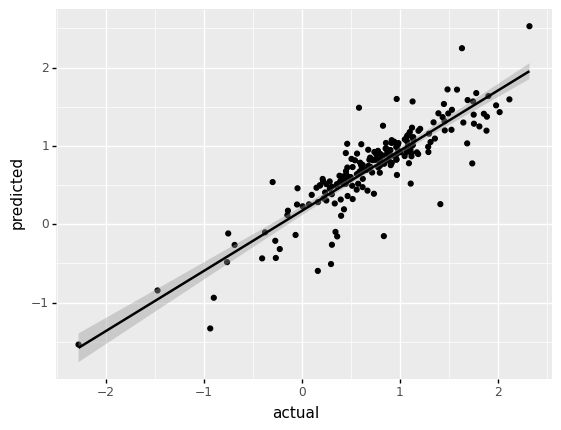

<ggplot: (8768612772413)>

In [406]:
ggplot(us_change_model_results_df) + aes(x='actual', y='predicted') + geom_point() + geom_smooth(method='lm')
# TODO: Review fes regression section

<AxesSubplot:xlabel='Date'>

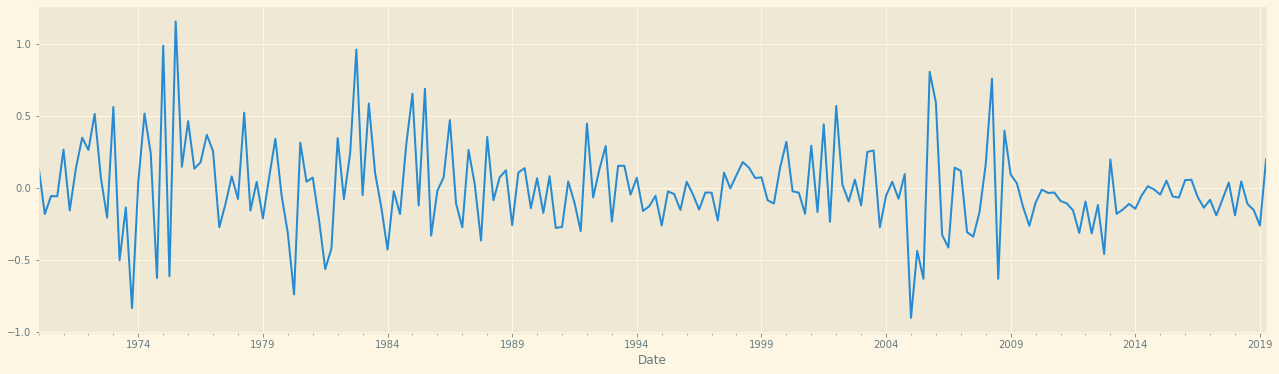

In [408]:
us_change_model_results_df = us_change_model_results_df.assign(residual=lambda df: df.actual - df.predicted)
us_change_model_results_df.residual.plot(figsize=(22, 6))

Therefore when fitting a regression model to time series data, it is common to find autocorrelation in the residuals. In this case, the estimated model violates the assumption of no autocorrelation in the errors, and our forecasts may be inefficient — there is some information left over which should be accounted for in the model in order to obtain better forecasts.

<AxesSubplot:ylabel='Density'>

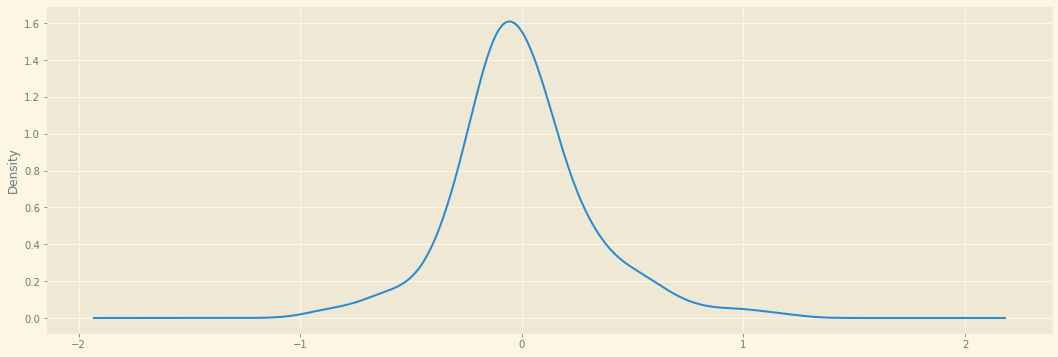

In [409]:
us_change_model_results_df.residual.plot.density(figsize=(18, 6))

In [18]:
from scipy.stats import ttest_1samp

statistic, pvalue = ttest_1samp(a=us_change_model_results_df.residual, popmean=0)
pvalue


0.9999999999999933

/var/folders/m5/zsd1m_dd4wd36c3_4bftzh280000gn/T/ipykernel_51533/123427363.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


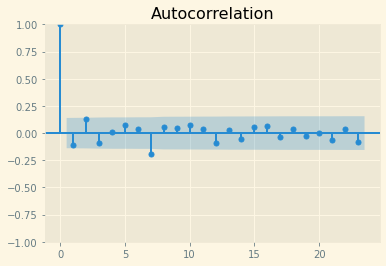

In [410]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
# pd.plotting.lag_plot(tute1_df.Sales, lag=4)

acf_plot = plot_acf(us_change_model_results_df.residual)
acf_plot.show()

In [573]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from statsmodels.api import ols

acorr_ljungbox(
    x=us_change_model_results_df.residual,
    lags=[10],
    return_df=True,
    boxpierce=True,
    model_df=5
)

# the results are significant, there might be autocorrelation

ImportError: cannot import name 'ols' from 'statsmodels.api' (/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/api.py)

### Residuals vs predicted values

<AxesSubplot:xlabel='predicted', ylabel='residual'>

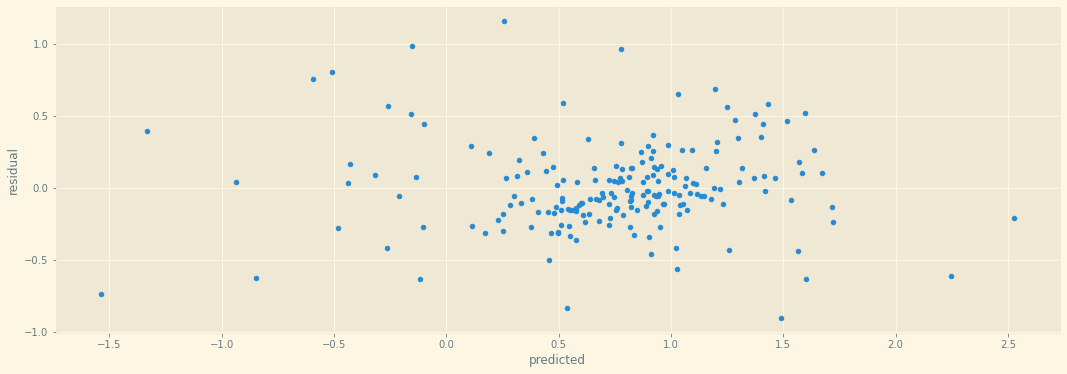

In [412]:
us_change_model_results_df.plot.scatter(
    x='predicted',
    y='residual',
    figsize=(18, 6)
)

# It is also necessary to plot the residuals against any predictors that are not in the model.
# If any of these show a pattern, then the corresponding
# predictor may need to be added to the model (possibly in a nonlinear form).

### Residuals vs predictors

/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


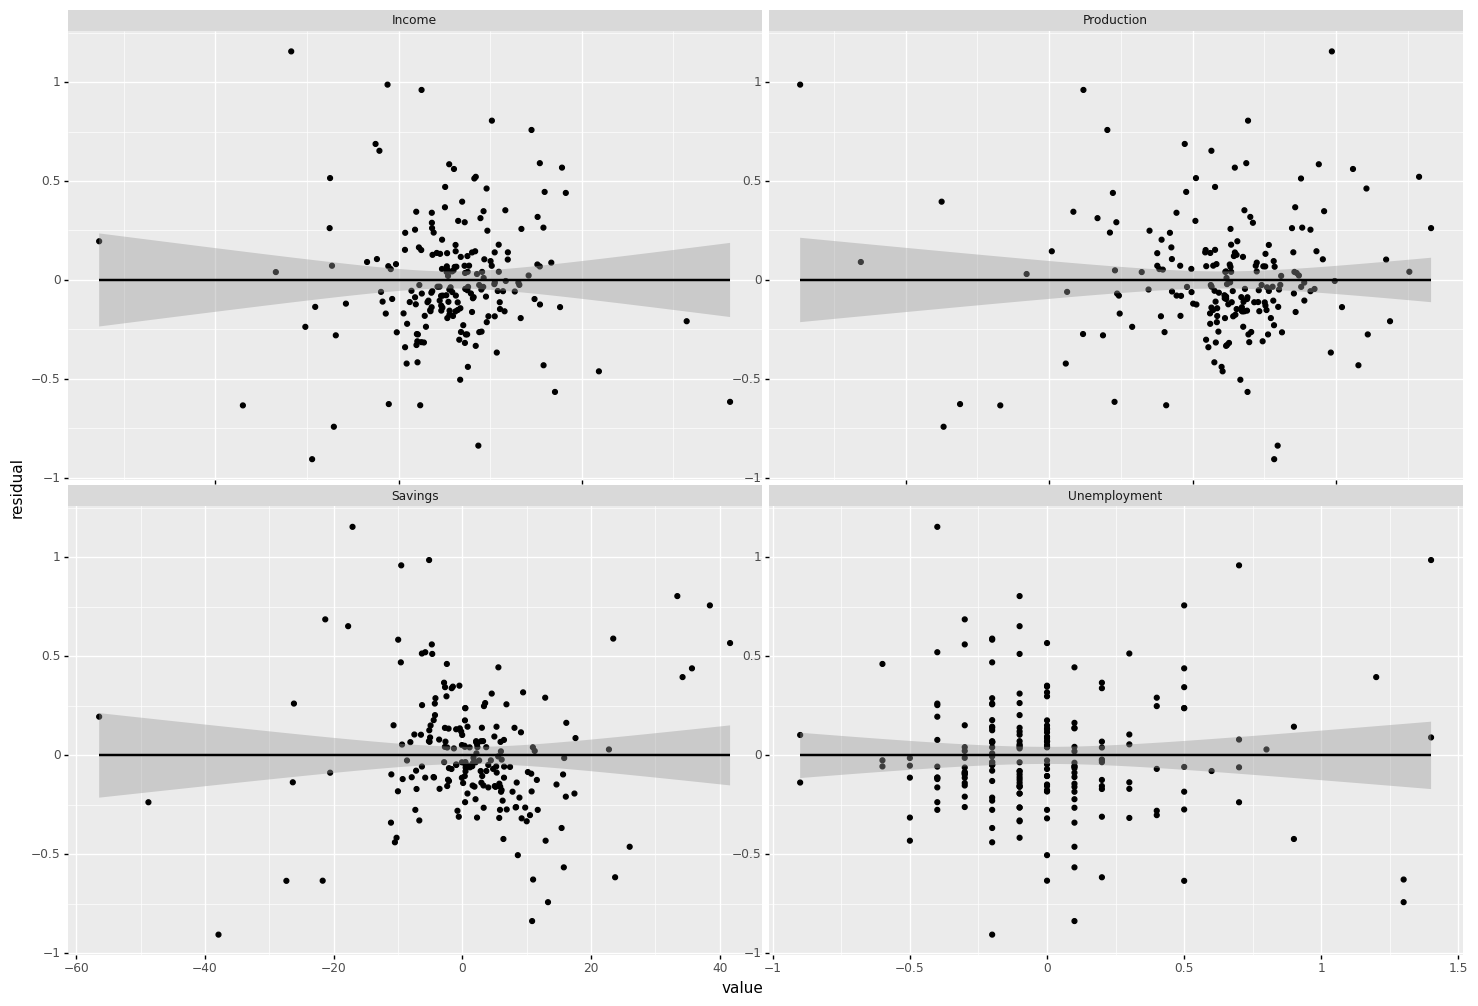

<ggplot: (8768630384415)>

In [64]:
(us_change_df.drop("Consumption", axis=1)
 .assign(residual=us_change_model_results_df.residual)
 .melt(id_vars='residual')
 .pipe(ggplot) +
    aes(x='value', y='residual') +
    geom_point() +
    geom_smooth(method='lm') +
    facet_wrap('variable', scales='free') +
    theme(figure_size=(18, 12))
)

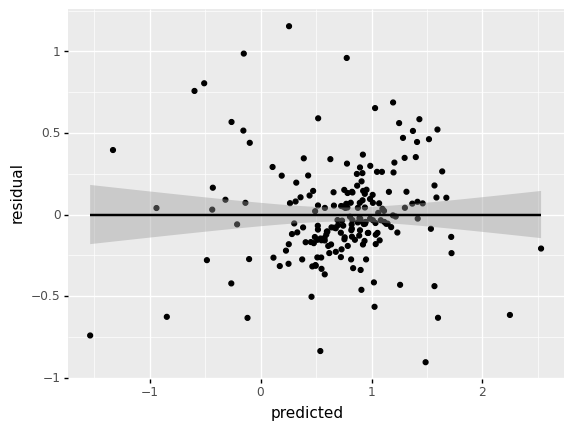

<ggplot: (8768630794036)>

In [65]:
# Residual plots against fitted values

(ggplot(us_change_model_results_df) +
    aes(x='predicted', y='residual') +
    geom_point() +
    geom_smooth(method='lm')
)

A plot of the residuals against the fitted values should also show no pattern. If a pattern is observed, there may be “heteroscedasticity” in the errors which means that the variance of the residuals may not be constant.  If this problem occurs, a transformation of the forecast variable such as a logarithm or square root may be required.

- There is a formal method for anomally\outlier\influential points detection.
- One source of outliers is incorrect data entry
- If such an observation is identified, and it has been recorded incorrectly, it should be corrected or removed from the sample immediately.
- Outliers also occur when some observations are simply different. In this case it may not be wise for these observations to be removed.
- It is wise to report results both with and without the removal of such observations.

### Some useful predictors

- Trend $y_t = β_0+β_1 t+ε_t$
- Dummy variables
    - Public Holiday
    - End of month
    - end of week
    - Season
    - Month
    - outlier Indicator (e.g. special event, do we expect it to repeat)
- Seasonal Dummy Variables
    - Dummy for each day or month

for monthly data, use 11 dummy variables; and for daily data, use six dummy variables, and so on.

The interpretation of each of the coefficients associated with the dummy variables is that it is a measure of the effect of that category relative to the omitted category.

#### Example: Beer Production

Text(0.5, 1.0, 'Beer production after 1992')

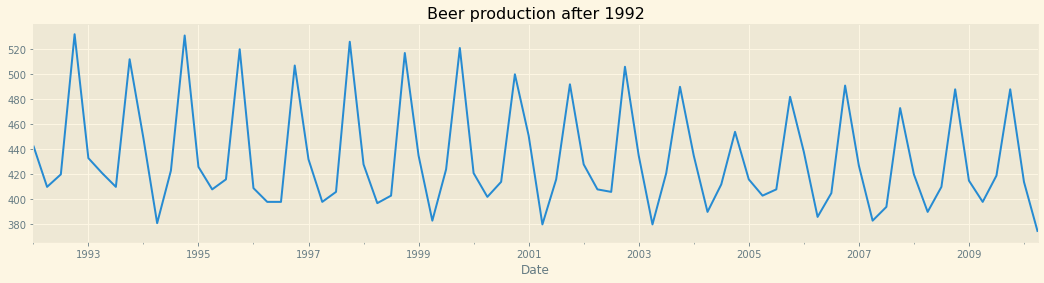

In [413]:
aus_production_df = (load_data("aus_production").assign(
    Date=lambda df: pd.to_datetime(df.Quarter.str.replace(" ", "-"))
)
.drop("Quarter", axis=1)
.set_index('Date')
)

recent_production_df = aus_production_df[aus_production_df.index.year >= 1992]
ax = recent_production_df.Beer.plot(figsize=(18, 4))
ax.set_title("Beer production after 1992")


We want to forecast the value of future beer production. We can model this data using a regression model with a linear trend and quarterly dummy variables,

$$
y_t=β_0+β1_t+β_{2d2,t}+β3_{d3,t}+β4_{d4,t}+ε_t
$$

where $d_{i,t}=1$  if  t  is in quarter  i  and 0 otherwise.

In [416]:
from statsmodels.tsa.seasonal import seasonal_decompose

trend = seasonal_decompose(x=recent_production_df.Beer,period=4, model='additive').trend

recent_production_df = recent_production_df.assign(
    Quarter=pd.Categorical(recent_production_df.index.quarter),
    # Trend is just the row number
    Trend = lambda df: df.reset_index().index
)

beer_fitted = ols(
    formula="Beer ~ Trend + Quarter",
    data=recent_production_df
).fit()



print(beer_fitted.summary())


                            OLS Regression Results                            
Dep. Variable:                   Beer   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     210.7
Date:                Tue, 08 Mar 2022   Prob (F-statistic):           6.97e-38
Time:                        13:08:36   Log-Likelihood:                -287.70
No. Observations:                  74   AIC:                             585.4
Df Residuals:                      69   BIC:                             596.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      441.4602      3.690    119.639   

Text(0.5, 1.0, 'Beer Fitted vs actual')

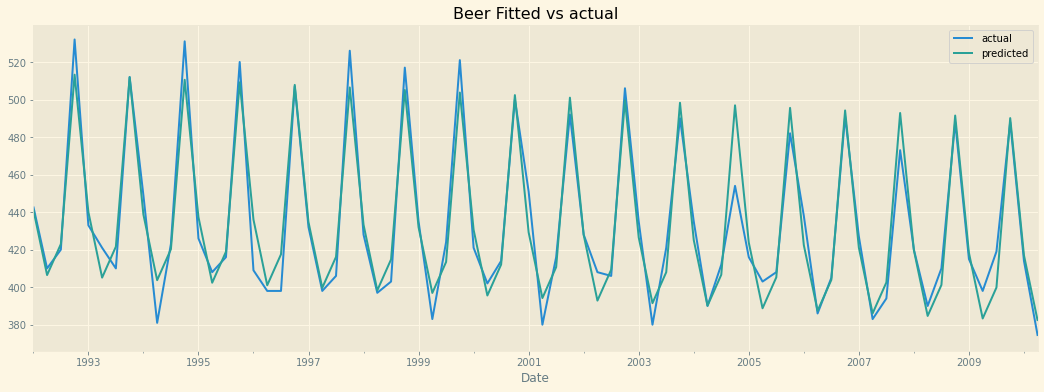

In [417]:
beer_model_results_df = pd.DataFrame({
    'actual': recent_production_df.Beer,
    'predicted': beer_fitted.predict(recent_production_df)
})

ax = beer_model_results_df.plot(figsize=(18, 6))
ax.set_title("Beer Fitted vs actual")

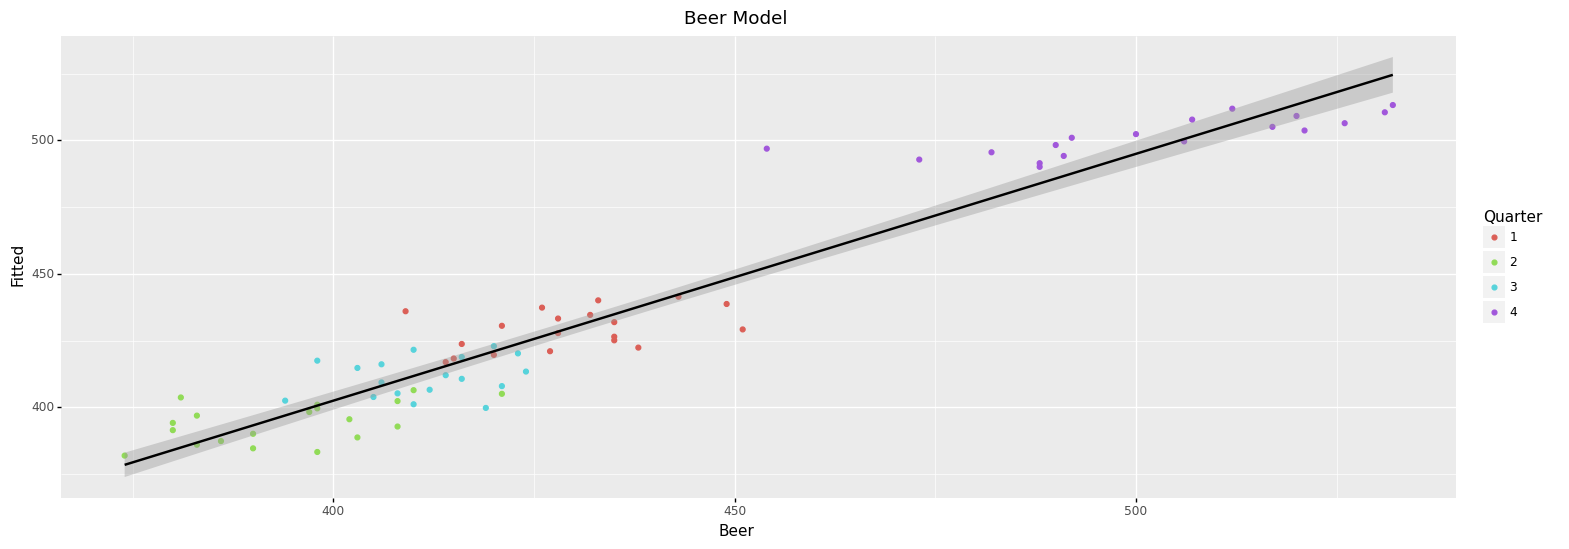

<ggplot: (8768635091842)>

In [121]:
(recent_production_df
 .assign(Fitted=beer_model_results_df.predicted)
 .pipe(ggplot) +
    aes(x='Beer', y='Fitted') +
    geom_point(aes(color='Quarter')) +
    geom_smooth(method='lm') +
    theme(figure_size=(18, 6)) +
    ggtitle("Beer Model")
)

# TODO: Review Tree models again

### Intervention variables

It is often necessary to model interventions that may have affected the variable to be forecast. For example
- competitor activity
- advertising expenditure
- industrial action
- and so on

When the effect lasts only for one period, we use a “spike” variable. This is a dummy variable that takes value one in the period of the intervention and zero elsewhere. A spike variable is equivalent to a dummy variable for handling an outlier.

Other interventions have an immediate and permanent effect. If an intervention causes a level shift (i.e., the value of the series changes suddenly and permanently from the time of intervention), then we use a “step” variable. A step variable takes value zero before the intervention and one from the time of intervention onward.

Another form of permanent effect is a change of slope. Here the intervention is handled using a piecewise linear trend; a trend that bends at the time of intervention and hence is nonlinear.

### Trading Days

- The number of trading days in a month can vary considerably and can have a substantial effect on sales data. To allow for this, the number of trading days in each month can be included as a predictor.

An alternative that allows for the effects of different days of the week has the following predictors: $x_i$ :- number of days in day ith of the week

### Distributed lags

It is often useful to include advertising expenditure as a predictor. However, since the effect of advertising can last beyond the actual campaign, we need to include lagged values of advertising expenditure. Thus, the following predictors may be used.

$$
x_1=\text{advertising for previous month}\\
x_2=\text{advertising for two months previously}\\
x_m=\text{advertising for m months previously.}
$$

### Easter

Easter differs from most holidays because it is not held on the same date each year, and its effect can last for several days. In this case, a dummy variable can be used with value one where the holiday falls in the particular time period and zero otherwise.

### Fourier Terms

- With Fourier terms, we often need fewer predictors than with dummy variables, especially when m is large. . This makes them useful for weekly data, for example, where  m≈52
 - For short seasonal periods (e.g., quarterly data), there is little advantage in using Fourier terms over seasonal dummy variables.


### Selecting Predictors

- Adjusted $R^2$
$$
\bar{R}^2=1−(1−R^2)\frac{T−1}{T−k−1}
$$

where T  is the number of observations and  k  is the number of predictors.

- Cross-validation :- LOOCV
- Akaike’s Information Criterion (AIC) TODO: Get intuition behind it
- Corrected Akaike’s Information Criterion
- BIC

### Forecasting with regression

- Ex-ante forecasts - only past information of predictors
- Ex-post forecasts - later information of the predictors. The model from which ex-post forecasts are produced should not be estimated using data from the forecast period.

### Example: Australian quarterly beer production



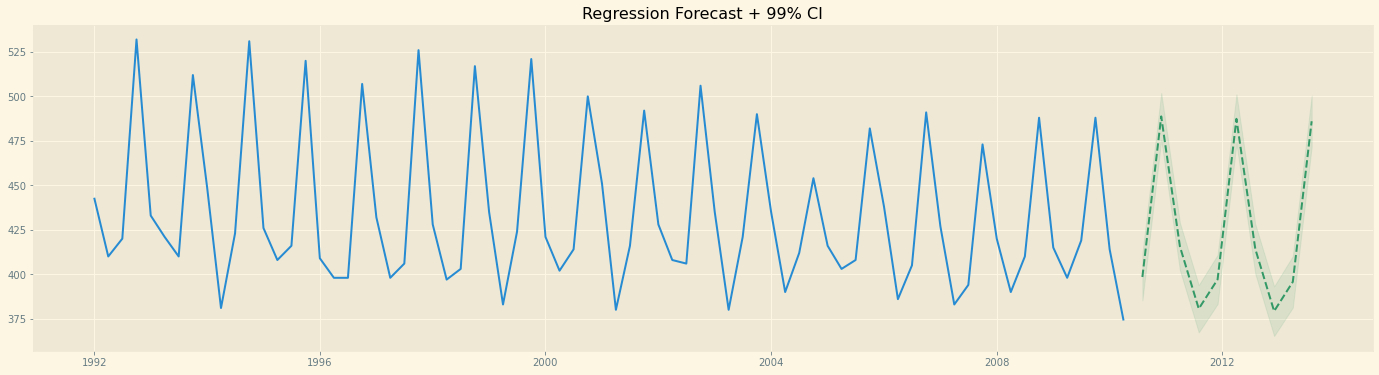

In [418]:
from dateutil.relativedelta import relativedelta
FORECAST_LENGTH = 10

# create plot and set sizes
fig, ax = plt.subplots()
fig.set_figwidth(24)
fig.set_figheight(6)

# plot the beer production and set title
ax.plot(recent_production_df.Beer)
ax.set_title("Regression Forecast + 99% CI")

# get last trend and last date in order to prepare forecast predictors
last_trend, last_quarter = recent_production_df[['Trend', 'Quarter']].iloc[-1]
last_date = recent_production_df.index[-1]

# prepare forecast predictors
forecast_df = pd.DataFrame({
    'Trend': np.arange(last_trend + 1, last_trend + FORECAST_LENGTH + 1),
    'Quarter': (np.arange(last_quarter, last_quarter + FORECAST_LENGTH) % 4) + 1
})

# prepare the forecast dates for the x axis
forecast_periods = np.arange(4, 4 * (FORECAST_LENGTH + 1), step=3)
forecast_dates = np.array(
    [last_date + relativedelta(months=i) for i in forecast_periods]
)

# get forecast predictions + 99% confidence intervals
result_forecast_df = (beer_fitted
 .get_prediction(forecast_df)
 .summary_frame(alpha=0.001)
)

# plot the forecast mean
ax.plot(forecast_dates, result_forecast_df["mean"], '--', lw=2, color='#339966')

# plot 99% confidence interval
ax.fill_between(
    forecast_dates,
    result_forecast_df.mean_ci_lower,
    result_forecast_df.mean_ci_upper,
    color='#339966',
    alpha=.1
)

### Scenario-based predictions

We can do a prediction w.r.t. different values of a predictor and plot the two predicted means and intervals.

### Building a predictive regression model

- We can use lagged values of the predictors as well if making forecasts of the predictors is hard

$$
y_{t+h}=β_0+β_1x_{1,t}+⋯+β_kx_{k,t}+ε_{t+h}
$$

### Prediction Intervals


### Nonlinear Regression

- A log transformation is specified as $logy=β_0+β_1logx+ε.$
- $β_1$  can be interpreted as an elasticity: $β_1$ is the average percentage change in y resulting from a 1% increase in x
- Logarithmic transformation must be on a positive variable, if it has 0s, log (x+1) is used
- We can use Piecewise Regression as well
- Nonlinear trend: $x_{1,t}=t, x_{2,t}=t^2$

#### Example: Piecewise Regression

Text(0.5, 1.0, 'Minutes running for Marathons')

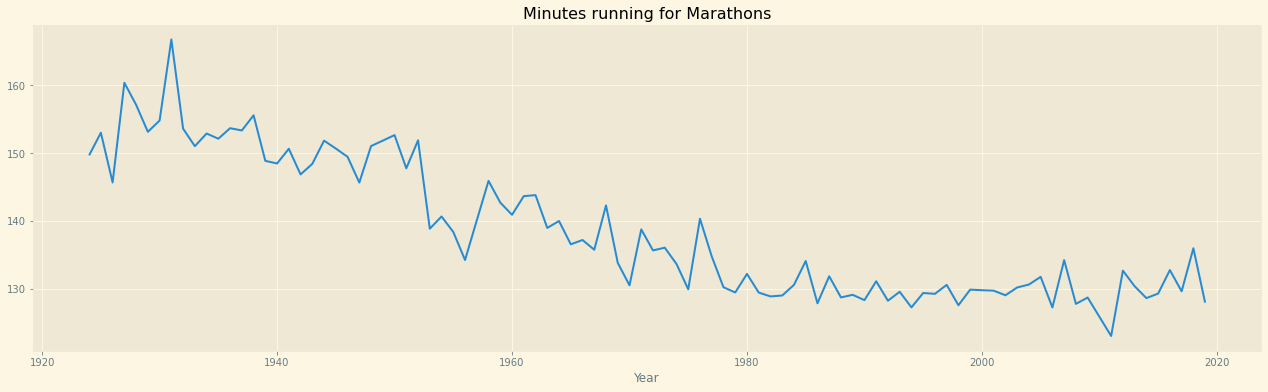

In [419]:
from sklearn.model_selection import train_test_split

boston_marathon_df = load_data("boston_marathon")
is_mens_open_division =  boston_marathon_df.Event == "Men's open division"

is_after_1994 = boston_marathon_df.Year >= 1924
boston_men_df = boston_marathon_df[is_after_1994 & is_mens_open_division]

boston_men_df = boston_men_df.assign(
    Minutes = pd.to_timedelta(boston_men_df.Time).dt.seconds / 60
).set_index("Year")

ax = boston_men_df.Minutes.plot(figsize=(22, 6))
ax.set_title("Minutes running for Marathons")
# boston_men_df.head(3)


In [385]:
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np
import piecewise_regression

x = np.arange(1, boston_men_df.shape[0] + 1)
y = boston_men_df.Minutes.values

pw_fit = piecewise_regression.Fit(x, y, n_breakpoints=2)
pw_fit.summary()


                    Breakpoint Regression Results                     
No. Observations                       96
No. Model Parameters                    6
Degrees of Freedom                     90
Res. Sum of Squares               1007.12
Total Sum of Squares              9690.36
R Squared                        0.896070
Adjusted R Squared               0.889063
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const                145.983          4.1       35.633      7.49e-55       137.84       154.12
alpha1               2.47667          1.5       1.6555         0.101     -0.49536       5.4487
beta1               -2.98116          1.5      -1.9924             -      -5.9537    -0.008593
beta2               0.511276       0.0588       8.6917             -      0.39441      0.62814
breakpoint1      

'\n                    Breakpoint Regression Results                     \n====================================================================================================\nNo. Observations                       96\nNo. Model Parameters                    6\nDegrees of Freedom                     90\nRes. Sum of Squares               1007.12\nTotal Sum of Squares              9690.36\nR Squared                        0.896070\nAdjusted R Squared               0.889063\nConverged:                           True\n====================================================================================================\n====================================================================================================\n                    Estimate      Std Err            t        P>|t|       [0.025       0.975]\n----------------------------------------------------------------------------------------------------\nconst                145.983          4.1       35.633      7.49e-55       137

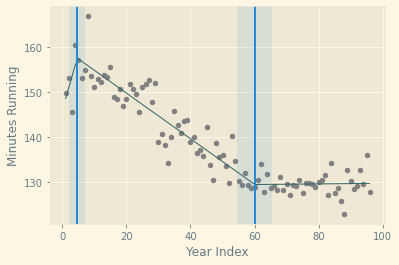

In [420]:
# Plot the data, fit, breakpoints and confidence intervals
ax = pw_fit.plot_data(color="grey", s=20)

pw_fit.plot_fit(color="#336666", linewidth=1)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()

plt.xlabel("Year Index")
plt.ylabel("Minutes Running")

plt.show()
plt.close()

In [517]:
# Problem 1
# Half-hourly electricity demand for Victoria, Australia is contained in vic_elec.
# Extract the January 2014 electricity demand, and aggregate this data to daily with daily 
# total demands and maximum temperatures.

vic_elec_df = (load_data("vic_elec")
 .assign(Time=lambda df: pd.to_datetime(df.Time))
)



is_2014 = vic_elec_df.Time.dt.year == 2014
is_january = vic_elec_df.Time.dt.month == 1

jan_2014_vic_elec_df = vic_elec_df[
    is_2014 & is_january
]

jan_2014_vic_elec_df
jan_2014_daily_vic_elec_df = jan_2014_vic_elec_df.groupby([
    jan_2014_vic_elec_df.Time.dt.date]
).agg({'Demand': 'sum', 'Temperature': 'max'})

jan_2014_daily_vic_elec_df.index = pd.to_datetime(
    jan_2014_daily_vic_elec_df.index
)

jan_2014_daily_vic_elec_df.head(3)

,Demand,Temperature
Time,,
2014-01-01,179453.793672,26.0
2014-01-02,190778.816406,23.0
2014-01-03,182892.121262,22.2


array([[<AxesSubplot:xlabel='Time'>],
       [<AxesSubplot:xlabel='Time'>]], dtype=object)

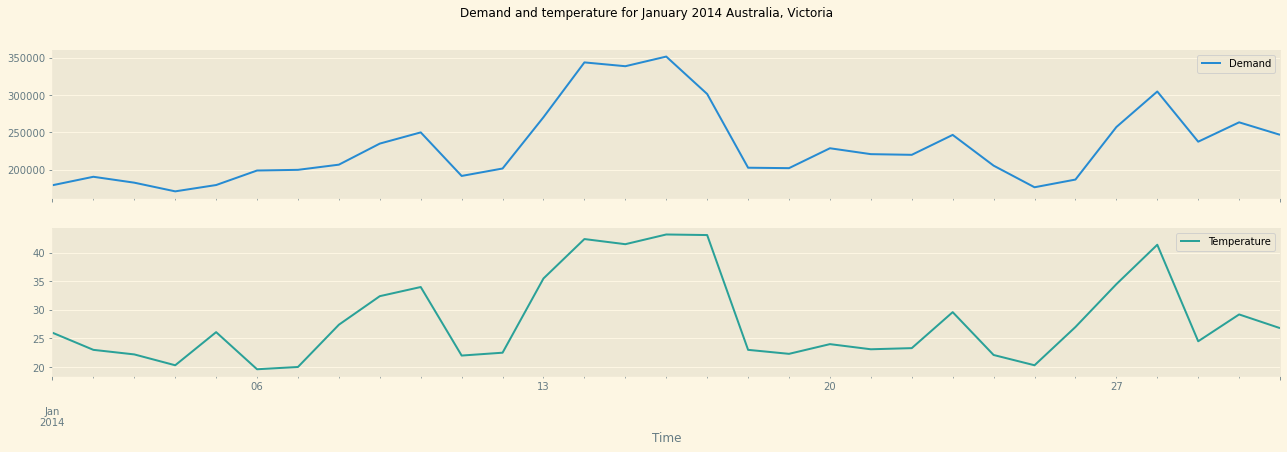

In [518]:
# Plot the data and find the regression model for Demand with temperature as a predictor variable. Why is there a positive relationship?
# Demand ~ Temperature

jan_2014_daily_vic_elec_df.plot(
    figsize=(22, 6),
    subplots=True,
    layout=(2, 1),
    title="Demand and temperature for January 2014 Australia, Victoria"
)


The two plots are very similiar. Lets explore the relationship there is between them

array([[<AxesSubplot:xlabel='Temperature', ylabel='Demand'>],
       [<AxesSubplot:xlabel='Temperature', ylabel='Demand'>]],
      dtype=object)

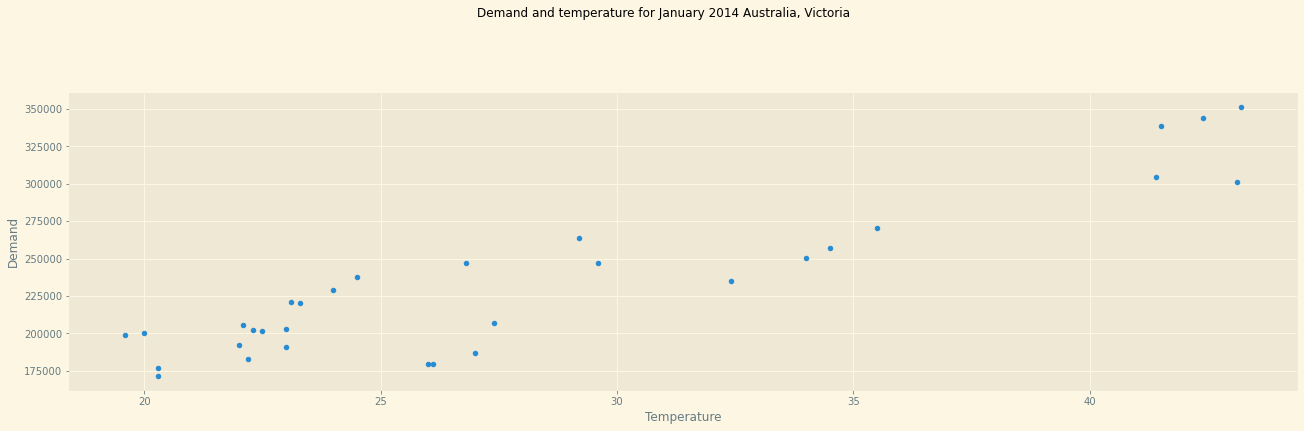

In [519]:
jan_2014_daily_vic_elec_df.plot.scatter(
    x="Temperature",
    y="Demand",
    figsize=(22, 12),
    subplots=True,
    layout=(2, 1),
    title="Demand and temperature for January 2014 Australia, Victoria"
)

It might be that there are two or more different distributions. Lets see the actual distributions of temperature and demand.

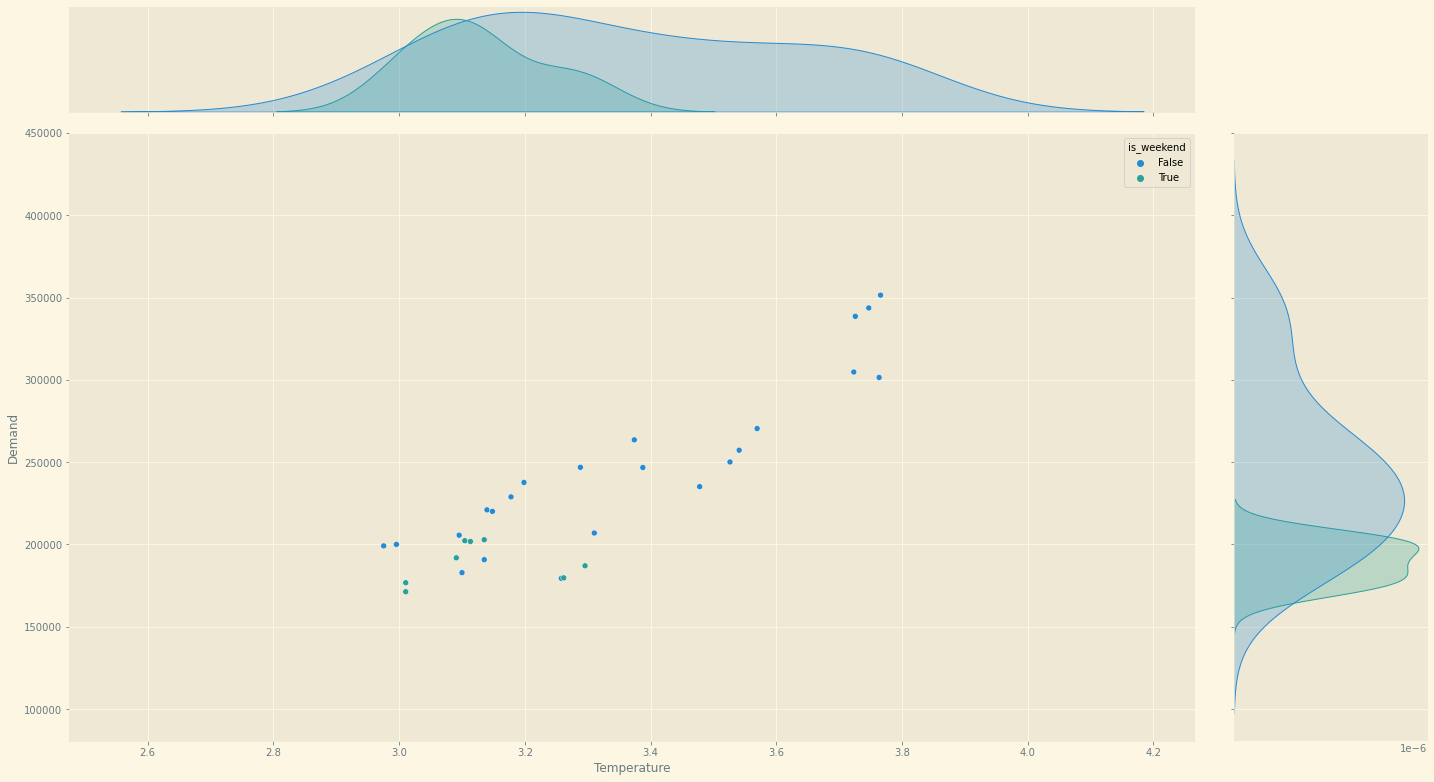

In [530]:
jan_2014_daily_vic_elec_df.plot

jan_2014_daily_vic_elec_df.index.dayofweek

jan_2014_daily_vic_elec_df = jan_2014_daily_vic_elec_df.assign(
    is_weekend=lambda df: df.index.dayofweek > 4,
    day_of_week=lambda df: df.index.dayofweek
)

# jan_2014_daily_vic_elec_df
g = sns.jointplot(
    data=jan_2014_daily_vic_elec_df.assign(Temperature=lambda df: np.log(df.Temperature)),
    x="Temperature",
    y="Demand",
    hue="is_weekend",
)

g.fig.set_figwidth(22)
g.fig.set_figheight(11.7)

# pd.to_datetime(jan_2014_daily_vic_elec_df.index).dayofweek


- We notice that the distribution for the weekends' demand is relatively low, but that could be from the fact that those 8 observations are all in a lower temperature by some chance (there are no weekend observations with higher temperatures). There is also lower variance
- We removed the hour data. That one could have given useful information

In [548]:
electricity_fitted = ols(
    formula="Demand ~ Temperature + is_weekend",
    data=jan_2014_daily_vic_elec_df
).fit()

print(electricity_fitted.summary())


                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     81.24
Date:                Thu, 10 Mar 2022   Prob (F-statistic):           2.20e-12
Time:                        12:16:26   Log-Likelihood:                -349.87
No. Observations:                  31   AIC:                             705.7
Df Residuals:                      28   BIC:                             710.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           7.644e+04   1.65

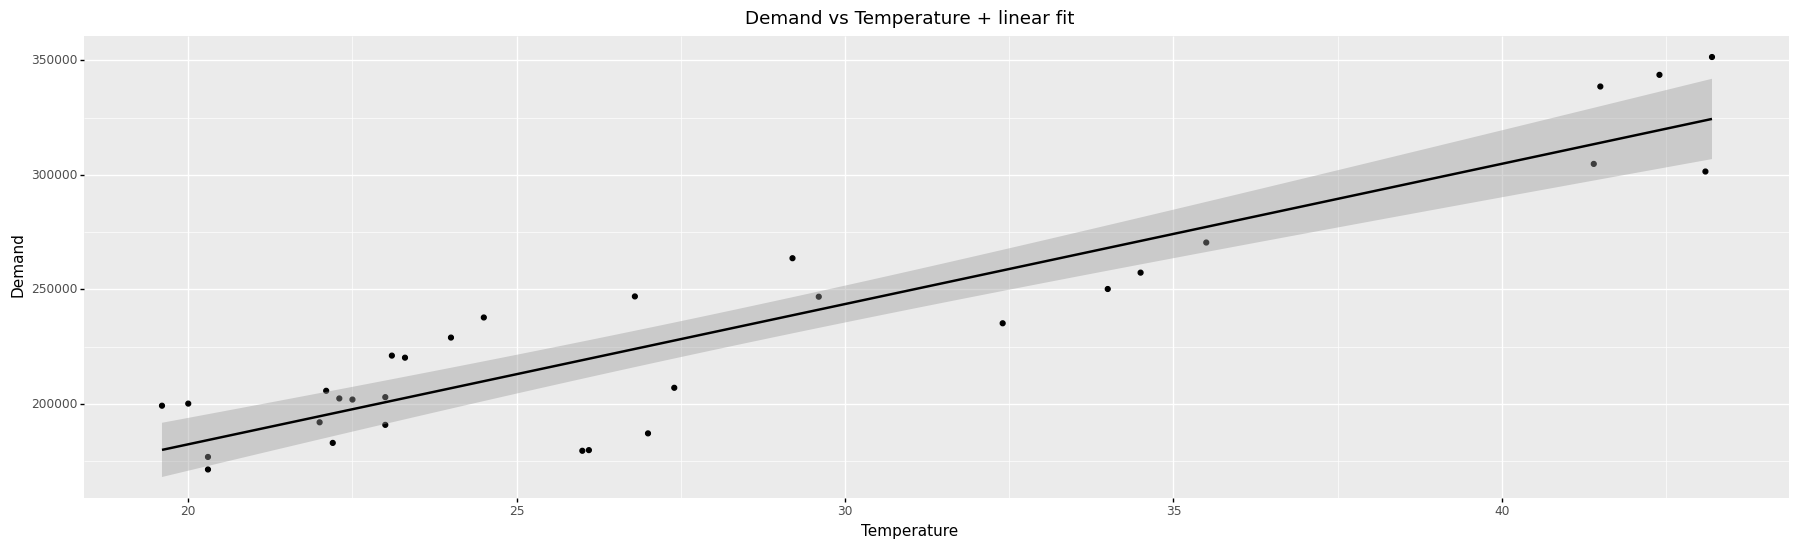

<ggplot: (8768602551312)>

In [525]:
(ggplot(jan_2014_daily_vic_elec_df) +
    aes(x='Temperature', y='Demand') +
    geom_point() +
    geom_smooth(method="lm") +
    theme(figure_size=(22, 6)) +
    ggtitle("Demand vs Temperature + linear fit")
)

<AxesSubplot:ylabel='Density'>

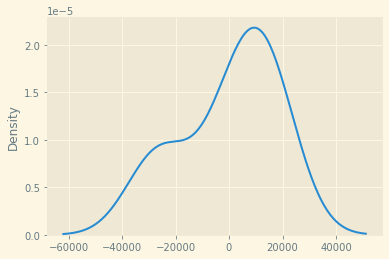

In [503]:
from scipy.stats import shapiro

# electricity_fitted.resid.plot(figsize=(22, 6))
sns.kdeplot(electricity_fitted.resid[jan_2014_daily_vic_elec_df.is_weekend])
# shapiro(electricity_fitted.resid)
# x

Relatively, with 1 degree change in the maximum temperature, the total demand changes with just above 6000$

In [575]:
from datetime import timedelta

# Use the model to forecast the electricity demand that you would expect for the next day if the maximum temperature was  
# 15∘C  and compare it with the forecast if the with maximum temperature was 35∘C . 

next_day = jan_2014_daily_vic_elec_df.index.max() + timedelta(days=1)

to_predict_df = (pd.DataFrame({
    'Temperature': [15, 35],
    'Time': [next_day, next_day]
})
 .set_index('Time')
 .assign(is_weekend=lambda df: df.index.dayofweek > 4)
)

prediction_results_df = (electricity_fitted
 .get_prediction(to_predict_df)
 .summary_frame()
)

prediction_results_df


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,143991.732847,8329.757790,126928.997501,161054.468192,99057.227600,188926.238093
1,257949.931315,9635.040787,238213.444956,277686.417674,211933.611188,303966.251442


eval_env: 1


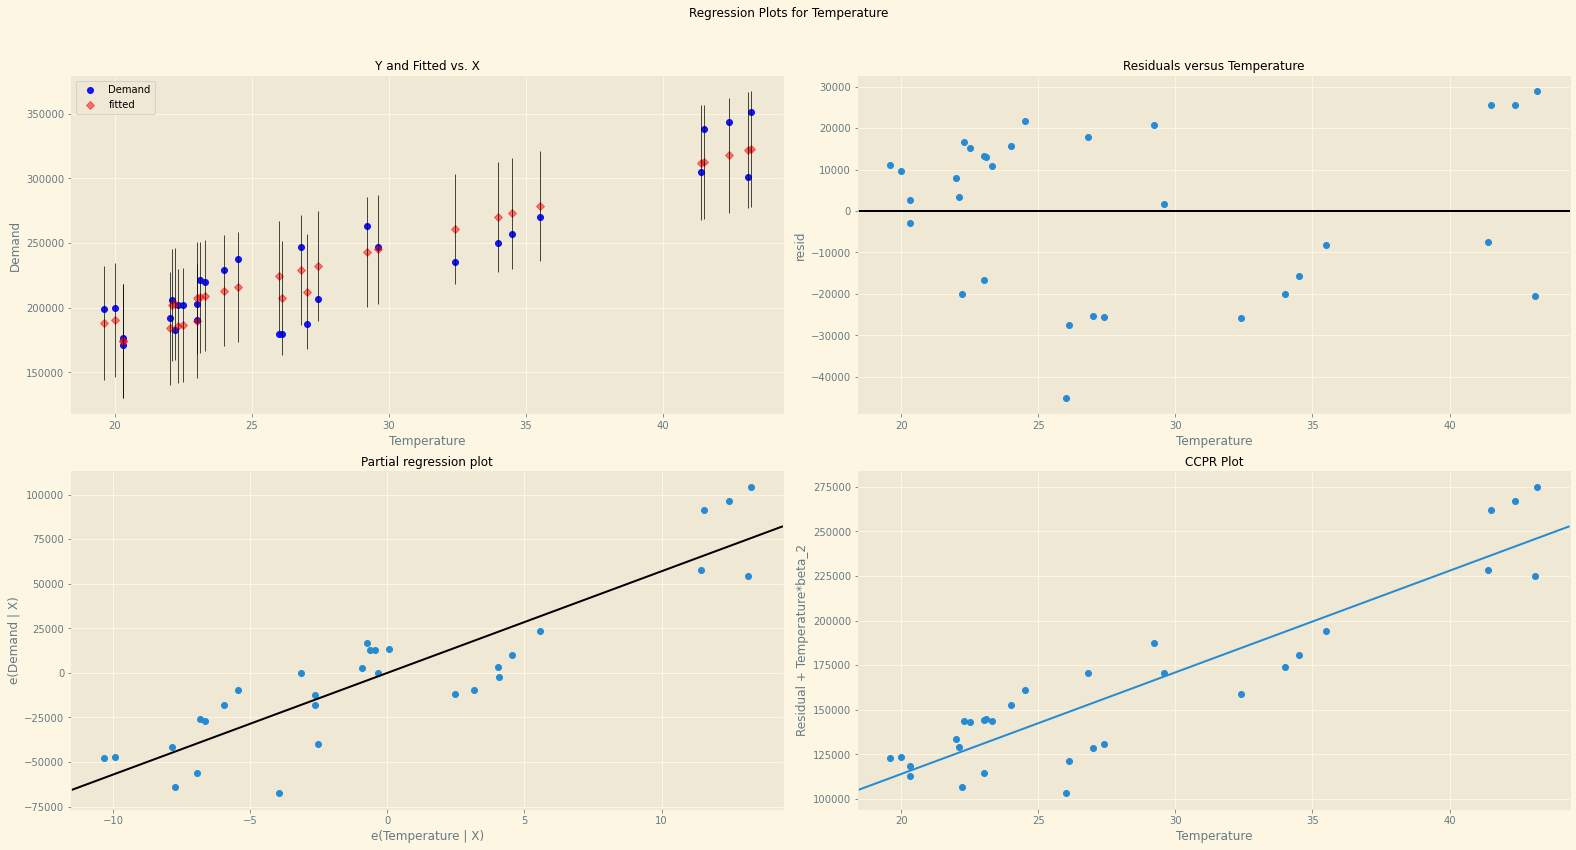

In [579]:
# Give prediction intervals for your forecasts.

# Plot Demand vs Temperature for all of the available data in vic_elec aggregated to daily total demand and maximum temperature.
# What does this say about your model?

fig = plt.figure(figsize=(22, 12))

#produce regression plots
fig = sm.graphics.plot_regress_exog(electricity_fitted, 'Temperature', fig=fig)



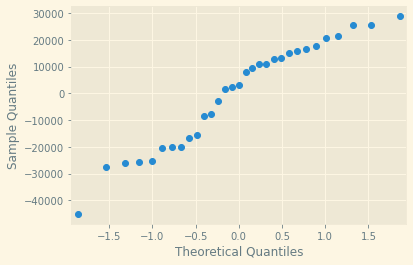

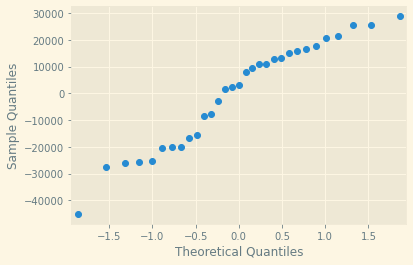

In [583]:
sm.graphics.qqplot(electricity_fitted.resid)